# YOLO
In yolo (you only look once) we will have B bounding boxes per pixel, and the pixels are large and cover the whole image.

The pixel in which the center of an object lies is responsible for detecting the object.

Each of the bounding boxes output is 5 numbers, (x,y) (the center, not corner) width, height, confidence.

Confidence is a prediction of IOU

Additionally, each cell predicts a probability distribution over class labels.




# Color module
We can use my attention mechanism to give some sort of a color module.

Say I have a variable number of colors N, and I want to map to a fixed number M.

We get M convolution filters.

We filter each image with each filter.  This gives an N x M array of images.

We then apply a softmax to it.  We then do matrix multiplication.



In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys
import pickle
import time
import random

# %matplotlib notebook
%matplotlib widget

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Include location of Python source scripts
sys.path.append(os.path.join(os.getcwd(),'source'))

# Data Exploration

### Initalize global variables

In [2]:
nclasses = 3
dtype = torch.float32
cwd = os.getcwd()
pwd = os.path.join(os.path.split(cwd)[0])

print(f'cwd: {cwd}')
print(f'pwd: {pwd}')

cwd: /home/abenneck/Desktop/yolo_model
pwd: /home/abenneck/Desktop


### Initialize a dataset of simulated images and visualze a GT example

In [7]:
from yolo_help import GroundTruthDataset

groundtruth = GroundTruthDataset()

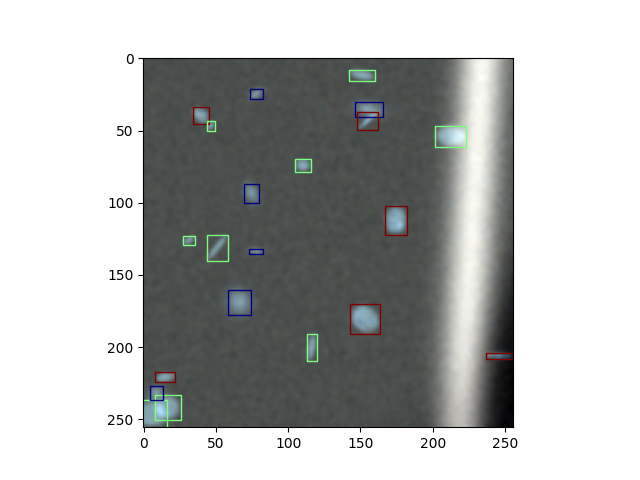

In [8]:
from yolo_help import bbox_to_rectangles, imshow

I,bbox,cl = groundtruth[0]
fig,ax = plt.subplots()
imshow(I,ax,cmap='gray')
polys = bbox_to_rectangles(bbox,fc='none')
polys.set_edgecolor(plt.cm.jet(cl*255//(nclasses-1)))
ax.add_collection(polys)

# The YOLO Model

### Variable Input Layer Example

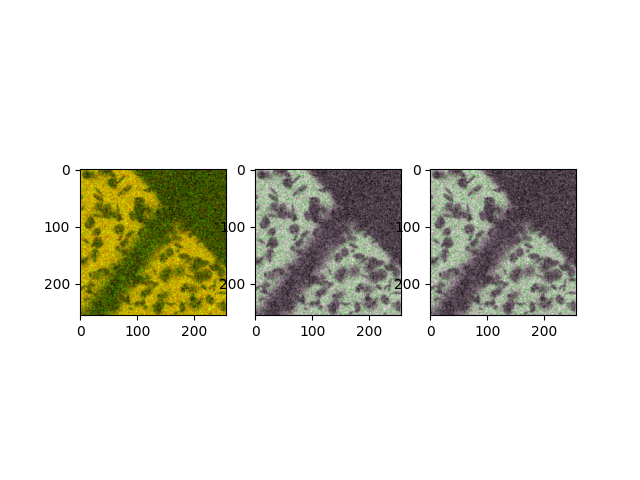

In [9]:
from yolo_help import VariableInputConv2d


layer = VariableInputConv2d(3)
fig,ax = plt.subplots(1,3)
I,bbox,cls = groundtruth[0]
imshow(I,ax[0])

r = torch.randperm(I.shape[0])
out1 = layer(torch.tensor(I,dtype=dtype)[None]).clone().detach()[0]
out2 = layer(torch.tensor(I,dtype=dtype)[r][None]).clone().detach()[0] 
imshow(out1,ax[1])
imshow(out2,ax[2])
# note the order of components doesn't matter

### Initalize a neural network following the YOLO framework

In [10]:
from yolo_help import Net

net = Net()

### Visualize example output from model

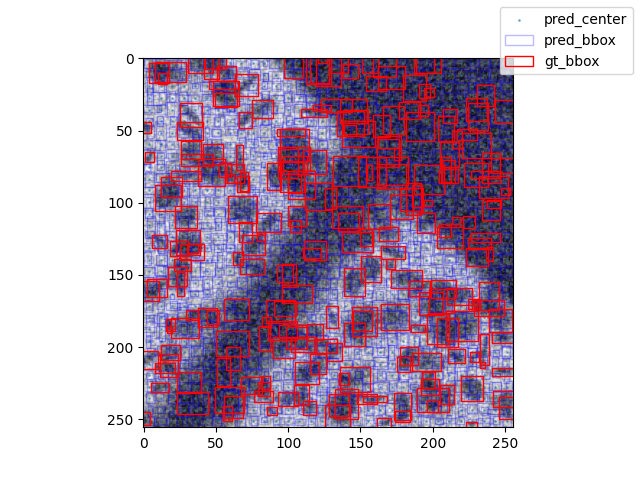

In [11]:
from yolo_help import convert_data

out = net(torch.tensor(I[None],dtype=dtype))
B = net.B
stride = net.stride

bboxes,data = convert_data(out,B,stride)

fig,ax = plt.subplots()
x = torch.arange(out.shape[-1])*stride + (stride-1)/2
y = torch.arange(out.shape[-2])*stride + (stride-1)/2
YX = torch.stack(torch.meshgrid(y,x,indexing='ij'),0)
ax.imshow(I[0],cmap='gray')
ax.scatter(YX[1].ravel(),YX[0].ravel(),s=1,alpha=0.5)
x = bboxes[...,0]
y = bboxes[...,1]
w = bboxes[...,2]
h = bboxes[...,3]
c = data[...,-1]
predicted_rectangles = bbox_to_rectangles(torch.stack( (x.ravel(),y.ravel(),w.ravel(),h.ravel()) ).T,fc='none',ec='b',alpha=c.clone().detach()*0.5)
ax.add_collection(predicted_rectangles,)

true_rectangles = bbox_to_rectangles(bbox,fc='none',ec='r')
ax.add_collection(true_rectangles,)
fig.legend(['pred_center','pred_bbox','gt_bbox'])
fig.canvas.draw()

### Add predicted bounding boxes to above figure

In [12]:
from yolo_help import get_assignment_inds


# transform the true bounding boxes
# to do this first we need an assignment to a given cell
shape = out.shape
B = net.B

assignment_inds,ious = get_assignment_inds(bboxes,bbox,shape,stride,B)
bboxes_assigned = bboxes[assignment_inds]
x = bboxes_assigned[...,0]
y = bboxes_assigned[...,1]
w = bboxes_assigned[...,2]
h = bboxes_assigned[...,3]
c = data[assignment_inds,-1]
predicted_rectangles = bbox_to_rectangles(torch.stack( (x.ravel(),y.ravel(),w.ravel(),h.ravel()) ).T,fc='none',ec='g',alpha=c.clone().detach())
ax.add_collection(predicted_rectangles,)

# Model Training

In [ ]:
from yolo_help import train_yolo_model

nepochs = 9854
lr = 1e-4
cls_loss = torch.nn.CrossEntropyLoss(reduction='sum')
resume = True # if True, will load a saved model

modelname = 'modelsave.pt'
optimizername = 'optimizersave.pt'
lossname = 'loss.pt'
outdir_model = os.path.join(cwd,'outputs','models',f'nepochs_{nepochs}')

net = train_yolo_model(nepochs, lr, cls_loss, outdir_model, modelname, optimizername, lossname, verbose=True, resume=resume)

# Post-Processing

### Filter candidate bboxes (best_bbox_per_cell + NMS)

In [18]:
from yolo_help import get_best_bounding_box_per_cell
from yolo_post_help import NMS, remove_low_conf_bboxes

def filter_model_outputs(outdir, net, best_bbox_filter = False, low_conf_filter = False, nms_filter = False):
    if not os.path.exists(outdir):
        print(f'Making new directory {outdir}')
        os.makedirs(outdir)
        
    if os.path.exists(os.path.join(outdir, 'all_gt_bbox.pkl')):
        # Save the gt_bbox, pred_bbox, and pred_score info for downstream analysis
        with open(os.path.join(outdir,'all_gt_bbox.pkl'),'rb') as f:
            all_gt_bbox = pickle.load(f)
        with open(os.path.join(outdir,'all_pred_bbox.pkl'),'rb') as f:
            all_pred_bbox = pickle.load(f)
        with open(os.path.join(outdir,'all_scores.pkl'),'rb') as f:
            all_scores = pickle.load(f)
        with open(os.path.join(outdir,'all_images.pkl'),'rb') as f:
            all_images = pickle.load(f)
        print(f'Loaded 4 files from {outdir}')
    else:
        all_pred_bbox = []
        all_scores = []
        all_gt_bbox = []
        all_images = []
        nimages_pq = 100

        groundtruth = GroundTruthDataset(reproducible = True)
        for i, gt in enumerate(groundtruth):
            # Quantify the model's performance against 'nimages_pq' simulated gt images
            if i >= nimages_pq:
                break
                
            # Initialize gt objects (bbox: [cx, cy, w, h, conf])
            I,bbox,cls = gt
            print(f'=== Starting groundtruth[{i}] ({len(bbox)} bboxes) ===')
        
            # Get model outputs for the ith image in the gt dataset
            out = net(torch.tensor(I,dtype=dtype)[None])
            bboxes,data = convert_data(out,net.B,net.stride)
            scores = data[:,-1]
            print(f'{len(bboxes)} bboxes output from model')
            bboxes_, scores_ = bboxes, scores
            
            # Reduces # of guesses by factor of 2
            if best_bbox_filter:
                start = time.time()
                bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,scores.clone().detach(),net.B)
                print(f'{len(bboxes_)} bboxes after getting best bbox per cell; Finished in {time.time() - start:.2f}s')
        
            # Remove bounding boxes below some conf threshold
            if low_conf_filter:
                start = time.time()
                bboxes_, scores_ = remove_low_conf_bboxes(bboxes_, scores_)
                print(f'{len(bboxes_)} bboxes after removing low conf bboxes; Finished in {time.time() - start:.2f}s')
            
            # Perform NMS on filtered guesses (Reduce by a factor of ~2
            if nms_filter:
                start = time.time()
                bboxes_,scores_ = NMS(bboxes_, scores_, nms_threshold = 0.9)
                print(f'{len(bboxes_)} bboxes after NMS; Finished in {time.time() - start:.2f}s\n')
            
            # Append outputs from current image to all outputs for downstream performance quantification and visualization
            all_gt_bbox.append(bbox)
            all_pred_bbox.append(bboxes_)
            all_scores.append(scores_)
            all_images.append(I)
    
        # Save the gt_bbox, pred_bbox, and pred_score info for downstream analysis
        with open(os.path.join(outdir,'all_gt_bbox.pkl'),'wb') as f:
            pickle.dump(all_gt_bbox,f)
        with open(os.path.join(outdir,'all_pred_bbox.pkl'),'wb') as f:
            pickle.dump(all_pred_bbox,f)
        with open(os.path.join(outdir,'all_scores.pkl'),'wb') as f:
            pickle.dump(all_scores,f)
        with open(os.path.join(outdir,'all_images.pkl'),'wb') as f:
            pickle.dump(all_images,f)
        print(f'Saved output .pkl files to {outdir}')

    return all_pred_bbox, all_scores, all_gt_bbox, all_images

# Load filtered outputs, or generate new ones if none exist in outdir
outdir_data = os.path.join(cwd,'outputs','data',f'nepochs_{nepochs}_raw')
all_pred_bbox, all_scores, all_gt_bbox, all_images = filter_model_outputs(outdir_data, net)

=== Starting groundtruth[0] (193 bboxes) ===
2048 bboxes output from model
=== Starting groundtruth[1] (204 bboxes) ===
2048 bboxes output from model
=== Starting groundtruth[2] (73 bboxes) ===
2048 bboxes output from model
=== Starting groundtruth[3] (278 bboxes) ===
2048 bboxes output from model
=== Starting groundtruth[4] (307 bboxes) ===
2048 bboxes output from model
=== Starting groundtruth[5] (229 bboxes) ===
2048 bboxes output from model
=== Starting groundtruth[6] (337 bboxes) ===
2048 bboxes output from model
=== Starting groundtruth[7] (186 bboxes) ===
2048 bboxes output from model
=== Starting groundtruth[8] (192 bboxes) ===
2048 bboxes output from model
=== Starting groundtruth[9] (126 bboxes) ===
2048 bboxes output from model
=== Starting groundtruth[10] (124 bboxes) ===
2048 bboxes output from model
=== Starting groundtruth[11] (270 bboxes) ===
2048 bboxes output from model
=== Starting groundtruth[12] (279 bboxes) ===
2048 bboxes output from model
=== Starting groundtrut

### Compare GT bounding boxes with filtered estimated bounding boxes

In [ ]:
nrow = 50
ncol = 2
fig, axs = plt.subplots(nrow, ncol, layout = 'tight')
i,j = 0,0

for idx, I in enumerate(all_images):
    pred_bb = all_pred_bbox[idx]
    pred_s = all_scores[idx]
    gt_bb = all_gt_bbox[idx]

    imshow(I, axs[i,j], cmap = 'gray')
    gt_polys = bbox_to_rectangles(np.asarray(gt_bb),fc='none')
    gt_polys.set_edgecolor('blue')
    axs[i,j].add_collection(gt_polys)
    
    # imshow(I,axs[i,j],cmap='gray')
    pred_polys = bbox_to_rectangles(np.asarray(pred_bb),fc='none')
    pred_polys.set_edgecolor('red')
    axs[i,j].add_collection(pred_polys)

    j += 1

    if j > ncol - 1:
        j = 0
        i += 1

fig.legend(['gt','pred'])
fig.set_size_inches(ncol*3,nrow*3)
plt.show()

## PR Curve Generation

In [ ]:
import importlib as imp
import yolo_post_help
imp.reload(yolo_post_help)
from yolo_post_help import compute_pr_curves, plot_pr_curves, get_mAP

all_pred_bbox, all_scores, all_gt_bbox, all_images = filter_model_outputs(outdir_data, net)
all_pred_bbox, all_scores, all_gt_bbox, all_images = [all_pred_bbox[0]], [all_scores[0]], [all_gt_bbox[0]], [all_images[0]]

out = compute_pr_curves(all_gt_bbox, all_pred_bbox, all_scores, outdir_data, verbose = True)
fig, axs = plot_pr_curves(out)
fig, axs = plot_pr_curves(out, condense = False)
mAP = get_mAP(out)
print(f'mAP: {mAP}')

# TODO: Only compute (p,r) if there is a score below conf_thresh. Otherwise, all tp/fp/fn labels remain the same (Should save <10min on first 10)

In [13]:
all_pred = [[0.112,0.8,0.61],[0.4,0.1],[0.99]]
all_pred_ravel = np.asarray([elem for small_arr in all_pred for elem in small_arr])
conf_threshold = [round(x,2) for x in list(np.arange(0.01,1.0,0.01))]
# np.asarray(conf_threshold) > np.min(all_pred_ravel)
min_score_below_conf = conf_threshold < np.min(all_pred_ravel)


In [14]:
np.min(all_pred_ravel)

0.1

### Daniel's PR Code

In [15]:
# from yolo_help import iou

# fig,ax = plt.subplots(2,2)
# ax = ax.ravel()
# ax1 = ax[1]
# ax2 = ax[2]
# ax3 = ax[3]
# ax = ax[0]
# hfig = display(fig,display_id=True)
# groundtruth = GroundTruthDataset(reproducible = True)

# iouthresh = 0.7
# thresholds = np.linspace(0,1,100)
# # we consider all the detections made by our model
# tp = np.zeros(len(thresholds)) # our model output matches a true bbox (and no other output matches it better)
# fp = np.zeros(len(thresholds)) # our model output is not the best match for a true bbox
# tppfn = np.zeros(len(thresholds)) # denominator in recall is just the number of true boxes
# for i, gt in enumerate(groundtruth):

#     ax.cla()
#     I,bbox,cls = gt
#     imshow(I,ax)
    
#     gtrect = bbox_to_rectangles(bbox,facecolor='none',ec='b')
#     ax.add_collection(gtrect)
#     with torch.no_grad():
#         out = net(torch.tensor(I[None],dtype=dtype))
    
#     bboxes,data = convert_data(out,net.B,net.stride)
#     scores = data[:,-1]
#     bboxes_,scores_ = bboxes,scores
#     prrect = bbox_to_rectangles(bboxes_,facecolor='none',ec='r',ls=':',alpha=scores_)
#     ax.add_collection(prrect)
    
#     # loop through the ground truth
#     for j,t in enumerate(thresholds):
#         if torch.any(scores_>t):
#             bboxes__ = bboxes_[scores_>t] 
#             # we need to find which ones in bboxes__ are matched ot which ones in in bbox
#             # and we need to know how many are left over in each set
#             # we need to make sure that this assignment is 1-1, or we're essentially double coun
            
#             ious = iou(bboxes__,bbox)
            
#             # for each true bbox, find the besta match
#             inds = torch.argmax(ious,0)
#             maxious = torch.amax(ious,0)
            
#             # count a true positive if the above maxious are greater than the thresh
#             # there can be at most len(bbox)
#             ind0 = np.argmax(ious,0)
#             ind1 = np.argmax(ious,1)
#             # only count the goodinds
#             goodinds = ind1[ind0] == torch.arange(len(ind0))
#             ntp = (maxious[goodinds]>iouthresh).sum()                        
#             tp[j] += ntp

                        
#             # every single other detection is a false positive
#             # if it was output by my model and exceeded the score threshold
#             # sometimes this is less than 0!
#             nfp = len(bboxes_[scores_>t])-ntp 
#             fp[j] += nfp
#             # true positive plus false positive is the total number of detections
#             # then we just need the total numberof true ones for recall (true positive + false negative)
#             tppfn[j] += bbox.shape[0]
#         else:
#             # if t == 1, then there will be no scores > t and the above will give errors
            
#             tp[j] += 0
#             fp[j] += 0
#             tppfn[j] += bbox.shape[0] 
#             # recall will be 0, 
#             # precision will be 0/0
                    
#     precision = tp / (tp+fp)
#     precision[np.isnan(precision)] = 1
#     recall = tp / tppfn
#     mean_precision = np.abs(np.sum( np.diff(recall)*(precision[1:]+precision[:-1])/2 ))
#     ax1.cla()
#     ax1.plot(recall,precision,marker='.')
#     ax1.scatter(recall[0],precision[0],c='r')
#     ax1.scatter(recall[-1],precision[-1],c='g')
#     ax1.set_xlim(0,1)
#     ax1.set_ylim(0,1)
#     ax1.set_xlabel('Recall')
#     ax1.set_ylabel('Precision')
    
#     ax2.cla()
#     ax2.set_title('Total TP over epoch')
#     ax2.plot(tp,marker='.')  
    
#     ax3.cla()
#     ax3.set_title('Total FP over epoch')
#     ax3.plot(fp,marker='.')    

#     fig.canvas.draw()
#     hfig.update(fig)
